## Notes

**TODO:**
0. Decide permance metric for the 2 datasets. Right now it's accuracy, is it OK for both?
1. Use stratified sampling in CV
2. Do gridsearch to find "good enough parameters"
3. Plot learning curves
4. Analyze bias/varinace from the curves
5. Change something to decrease varinace/bias (not down what)
6. Once learning curves are somehow OK, choose 1-2 params to tweak manually plotting model complexity
7. Finally, check performance on test set

Bias / Variance analysis
- Improve accuracy (or whatever other metric)
- Reduce variance if it's high
- Reduce bias if it is too high



## Imports

In [1]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from keras.datasets import fashion_mnist
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


## Fashion MNIST

In [2]:
# Get dataset
(fm_x_train, fm_y_train), (fm_x_test, fm_y_test) = fashion_mnist.load_data()

# Reshape to 2D
fm_x_train = fm_x_train.reshape(fm_x_train.shape[0], -1)
fm_x_test = fm_x_test.reshape(fm_x_test.shape[0], -1)

# Only keep 5 classes (out of 10) simplify dataset
classes_to_keep = [0, 1, 2, 3, 4]
fm_x_train = fm_x_train[np.isin(fm_y_train, classes_to_keep)]
fm_y_train = fm_y_train[np.isin(fm_y_train, classes_to_keep)]
fm_x_test = fm_x_test[np.isin(fm_y_test, classes_to_keep)]
fm_y_test = fm_y_test[np.isin(fm_y_test, classes_to_keep)]

# Only use a subset of the dataset (for performance)
subset_ratio = 0.2

# Misuse StratifiedShuffleSplit to get a smaller dataset using stratified sampling on labels
sss = StratifiedShuffleSplit(n_splits=1, train_size=subset_ratio, random_state=42)
subset_index, _ = list(sss.split(fm_x_train, fm_y_train))[0]
fm_x_train = fm_x_train[subset_index]
fm_y_train = fm_y_train[subset_index]

fm_x_train.shape

(6000, 784)

In [3]:
# Check that labels are balanced
unique, counts = np.unique(fm_y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 1200],
       [   1, 1200],
       [   2, 1200],
       [   3, 1200],
       [   4, 1200]], dtype=int64)

## Adult Census

In [4]:
import os
os.environ['KAGGLE_USERNAME'] = "fdmnio"
os.environ['KAGGLE_KEY'] = "ae4bbd4616942d653ead213caff70ffc"
!kaggle datasets download -d uciml/adult-census-income

import zipfile
zipref = zipfile.ZipFile('adult-census-income.zip', 'r')
zipref.extractall()
zipref.close()
!ls

adult-census-income.zip: Skipping, found more recently modified local copy (use --force to force download)


'ls' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
ac_df = pd.read_csv("adult.csv", na_values="?")

# drop rows with na values

ac_df = ac_df.dropna()
ac_df.head()

# encode string categories
categorical_cols = ["workclass", "education", "marital.status", "occupation", "relationship", "race", "sex", "native.country"]
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ac_df[:] = ac_df[:].apply(lambda col: le.fit_transform(col))

# separate features and labels
ac_x = ac_df.drop(["income"], axis=1)
ac_y = ac_df["income"]

# One hot encode categorical features
ac_x = pd.get_dummies(ac_x, columns=categorical_cols, drop_first=True)
ac_x.head()

# Separate train and test data
ac_x_train, ac_x_test, ac_y_train, ac_y_test = train_test_split(
    ac_x, 
    ac_y, 
    test_size=0.2, 
    random_state=100,
    stratify=ac_y)

# Scale numerical features
numerical_cols = [x for x in list(ac_x_train.columns) if x not in categorical_cols]
from sklearn.preprocessing import MinMaxScaler
scaler_train = MinMaxScaler()
ac_x_train.loc[:, numerical_cols] = scaler_train.fit_transform(ac_x_train.loc[:, numerical_cols])
scaler_test = MinMaxScaler()
ac_x_test.loc[:, numerical_cols] = scaler_test.fit_transform(ac_x_test.loc[:, numerical_cols])

ac_x_train.head()

C:\Users\FedericoMeini\Anaconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\FedericoMeini\Anaconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,workclass_1,workclass_2,workclass_3,workclass_4,...,native.country_31,native.country_32,native.country_33,native.country_34,native.country_35,native.country_36,native.country_37,native.country_38,native.country_39,native.country_40
15589,0.253521,0.147172,0.800000,0.0,0.0,0.419355,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22390,0.380282,0.515300,0.800000,0.0,0.0,0.483871,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8491,0.380282,0.521962,0.533333,0.0,0.0,0.634409,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25387,0.338028,0.437469,0.800000,0.0,0.0,0.634409,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
28383,0.169014,0.531191,0.800000,0.0,0.0,0.473118,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Cross validation Score

**TODO**: Which score function (accuracy vs?) for the two datasets, why do they make sense?

In [6]:
def get_train_data(dataset_id):
    if dataset_id == "fm":
      x_train = fm_x_train
      y_train = fm_y_train
    if dataset_id == "ac":
      x_train = ac_x_train
      y_train = ac_y_train
    return x_train, y_train

def get_scoring_function(dataset_id):
    if dataset_id == "fm":
      return "accuracy"
    if dataset_id == "ac":
      return "f1"

def get_dataset_name(dataset_id):
  if dataset_id == "fm":
      return "Fashion MNIST"
  if dataset_id == "ac":
    return "Adult Census Income"

def compute_mean_cv_score(classifier, dataset_id, cv=5, scoring="accuracy"):
  x_train, y_train = get_train_data(dataset_id)
  scoring = get_scoring_function(dataset_id)
  return cross_val_score(classifier, x_train, y_train, cv=cv, scoring=scoring, n_jobs=-1).mean()

## Learning curves

### Base

In [7]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring="accuracy"):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    # TODO: which score is used??
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

### Functions

**TODO**: Which score function (accuracy vs?) for the two datasets, why do they make sense?

In [8]:
def plot_learning_curves(classifier, dataset_id, scoring="accuracy"):
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))

    # prepare plot
    dataset_name = get_dataset_name(dataset_id)
    title = "Learning Curves for " + classifier.__class__.__name__ + " on " + dataset_name
    cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

    # get data
    x_train, y_train = get_train_data(dataset_id)

    # choose scoring
    scoring = get_scoring_function(dataset_id)

    # plot
    plot_learning_curve(classifier, title, x_train, y_train, axes=axes, ylim=(0.5, 1.01),
                        cv=cv, n_jobs=-1, scoring=scoring)
    plt.show()

# Decision Tree
*For the decision tree, you should implement or steal a decision tree algorithm (and by "implement or steal" I mean "steal"). Be sure to use some form of pruning. You are not required to use information gain (for example, there is something called the GINI index that is sometimes used) to split attributes, but you should describe whatever it is that you do use.*

**TODO**: Talk about pre-prenuning (max-deoth, ...) and post-pruning (ccp_alpha) 

## DT - Fashion MNIST

In [15]:
fm_tree = DecisionTreeClassifier(min_samples_leaf=5, max_depth=10, ccp_alpha=0.001, random_state=42)
compute_mean_cv_score(fm_tree, "fm")

0.8261666666666667

In [11]:
fm_tree = DecisionTreeClassifier(random_state=42)
params = {
    "criterion": ("gini", "entropy"),
    "max_depth": [10, 20, 30],
    #"min_samples_split": [5, 10],
    "ccp_alpha": [0, 0.001],
    "min_samples_leaf": [5, 10]
}
fm_tree_gcv = GridSearchCV(fm_tree, params, scoring=get_scoring_function("fm"), n_jobs=-1, verbose=5)
fm_tree_gcv.fit(fm_x_train, fm_y_train)
fm_tree_gcv.best_params_

fm_tree_tuned = fm_tree_gcv.best_estimator_
compute_mean_cv_score(fm_tree_tuned, "fm")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   27.2s finished


0.8280000000000001

In [12]:
fm_tree_gcv.best_params_

{'ccp_alpha': 0.001,
 'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 5}

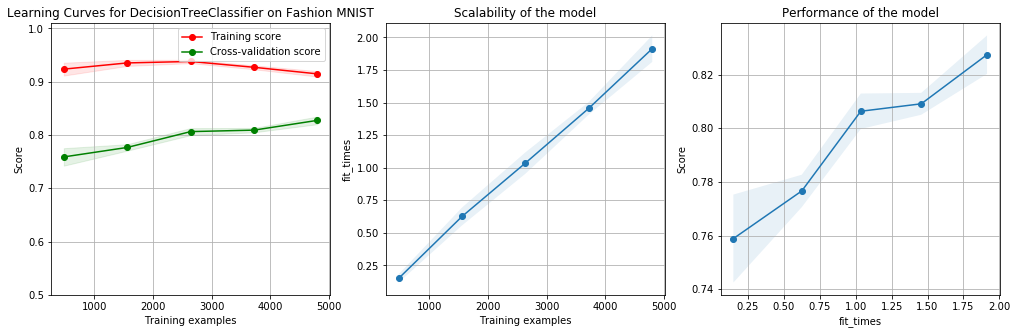

In [13]:
plot_learning_curves(fm_tree_tuned, "fm")

## DT - Income

In [14]:
ac_tree = DecisionTreeClassifier(max_depth=30, random_state=42)
ac_tree.fit(ac_x_train, ac_y_train)
compute_mean_cv_score(ac_tree, "ac")

0.619430205584384

In [17]:
ac_tree = DecisionTreeClassifier()
params = {
    "criterion": ("gini", "entropy"),
    "max_depth": [5, 7, 10, 20, 30, 50],
    "min_samples_split": [5, 10, 20],
    "ccp_alpha": [0, 0.001, 0.01, 0.1],
    "min_samples_leaf": [5, 10, 20]
}
ac_tree_gcv = GridSearchCV(ac_tree, params, scoring=get_scoring_function("ac"), n_jobs=-1, verbose=5)
ac_tree_gcv.fit(ac_x_train, ac_y_train)
ac_tree_gcv.best_params_

ac_tree_tuned = ac_tree_gcv.best_estimator_
compute_mean_cv_score(ac_tree_tuned, "ac")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  1.3min finished


0.6627844676795067

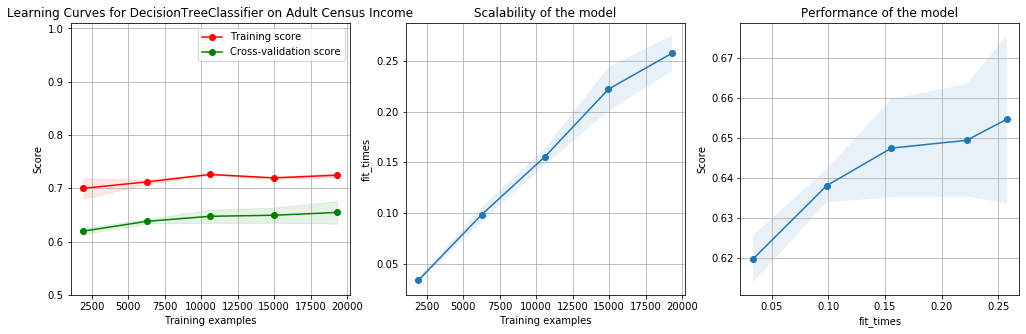

In [18]:
ac_tree_tuned.fit(ac_x_train, ac_y_train)
plot_learning_curves(ac_tree_tuned, "ac")

Max depth to have the tree not overfit

# kNN
*You should "implement" (the quotes mean I don't mean it: steal the code) kNN. Use different values of k.*

## kNN - Fashion MNIST

In [19]:
fm_knn = KNeighborsClassifier(n_neighbors=5, leaf_size=100, n_jobs=-1)
compute_mean_cv_score(fm_knn, "fm")

0.8625

In [20]:
fm_knn = KNeighborsClassifier(n_jobs=-1)
params = {
    "n_neighbors": [3, 5, 10, 20],
    "leaf_size": [10, 50, 100]
}
fm_knn_gcv = GridSearchCV(fm_knn, params, scoring=get_scoring_function("fm"), n_jobs=-1, verbose=5)
fm_knn_gcv.fit(fm_x_train, fm_y_train)
fm_knn_gcv.best_params_

fm_knn_tuned = fm_knn_gcv.best_estimator_
compute_mean_cv_score(fm_knn_tuned, "fm")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  60 | elapsed:  1.3min remaining:   15.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.4min finished


0.8633333333333333

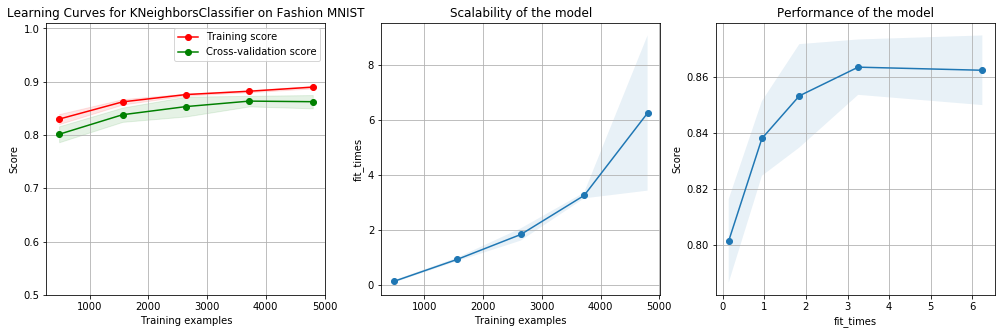

In [22]:
plot_learning_curves(fm_knn_tuned, "fm")

## kNN - Adult Census Income

In [23]:
ac_knn = KNeighborsClassifier(n_jobs=-1)
compute_mean_cv_score(ac_knn, "ac")

0.6204664678186399

In [28]:
ac_knn = KNeighborsClassifier(n_jobs=-1)
params = {
    "n_neighbors": [3, 5, 7, 10, 15, 20],
    "leaf_size": [1, 5, 10, 20]
}
ac_knn_gcv = GridSearchCV(ac_knn, params, scoring=get_scoring_function("ac"), n_jobs=-1, verbose=5)
ac_knn_gcv.fit(ac_x_train, ac_y_train)
ac_knn_gcv.best_params_

ac_knn_tuned = ac_knn_gcv.best_estimator_
compute_mean_cv_score(ac_knn_tuned, "ac")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.6min finished


0.6204664678186399

In [29]:
ac_knn_gcv.best_params_

{'leaf_size': 1, 'n_neighbors': 5}

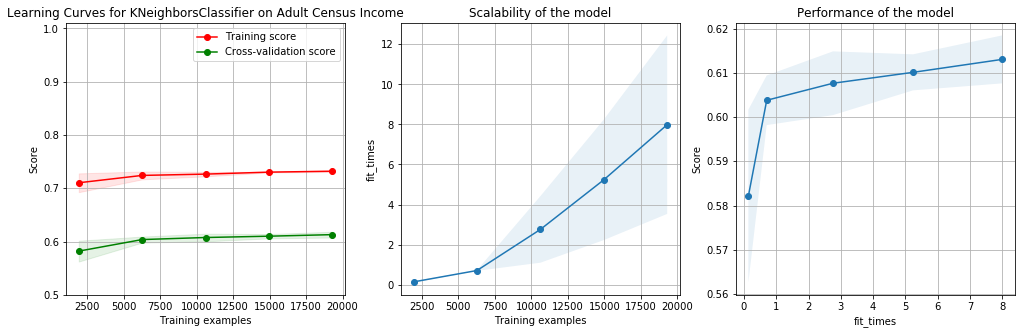

In [30]:
plot_learning_curves(ac_knn_tuned, "ac")

# SVM
*You should implement (for sufficiently loose definitions of implement including "download") SVMs. This should be done in such a way that you can swap out kernel functions. I'd like to see at least two.*

**Notes**
- SVM are sensible to scaling. I scaled the Adult dataset. Fashion MNIST is already scaled.

## SVM - Fashion MNIST

In [32]:
fm_svm = svm.SVC()
compute_mean_cv_score(fm_svm, "fm")

0.8863333333333333

In [36]:
fm_svm = svm.SVC()
params = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
    "C": [1, 1.5, 2, 3]
}
fm_svm_gcv = GridSearchCV(fm_svm, params, scoring=get_scoring_function("fm"), n_jobs=-1, verbose=5)
fm_svm_gcv.fit(fm_x_train, fm_y_train)
fm_svm_gcv.best_params_

fm_svm_tuned = fm_svm_gcv.best_estimator_
compute_mean_cv_score(fm_svm_tuned, "fm")

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 10.3min finished


0.8961666666666666

In [37]:
fm_svm_gcv.best_params_ # C could be the one for model complexity

{'C': 3, 'gamma': 'scale', 'kernel': 'rbf'}

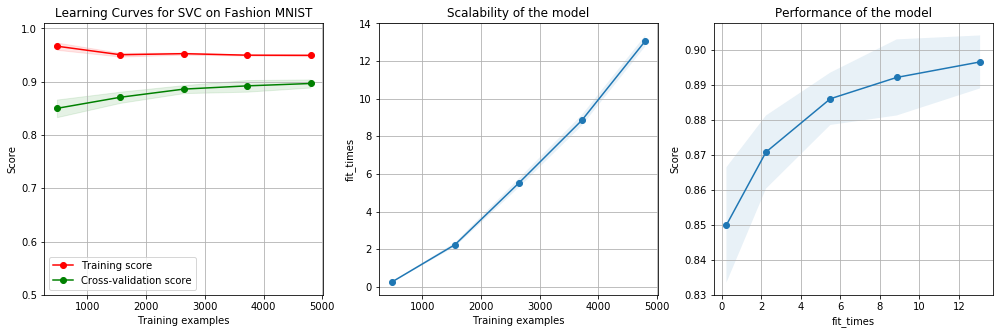

In [38]:
plot_learning_curves(fm_svm_tuned, "fm")

## SVM - Adult Census

In [21]:
# TODO: try several kernels
ac_svm = svm.SVC()
compute_mean_cv_score(ac_svm, "ac")

0.6504905149304656

In [39]:
ac_svm = svm.SVC()
params = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
    "C": [1, 1.5, 2, 3]
}
ac_svm_gcv = GridSearchCV(ac_svm, params, scoring=get_scoring_function("ac"), n_jobs=-1, verbose=5)
ac_svm_gcv.fit(ac_x_train, ac_y_train)
ac_svm_gcv.best_params_

ac_svm_tuned = ac_svm_gcv.best_estimator_
compute_mean_cv_score(ac_svm_tuned, "ac")

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  5.1min
C:\Users\FedericoMeini\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 16.9min finished


0.6572477216558519

In [42]:
ac_svm_gcv.best_params_ # TODO: Try polynomial grae, C values

{'C': 3, 'gamma': 'scale', 'kernel': 'poly'}

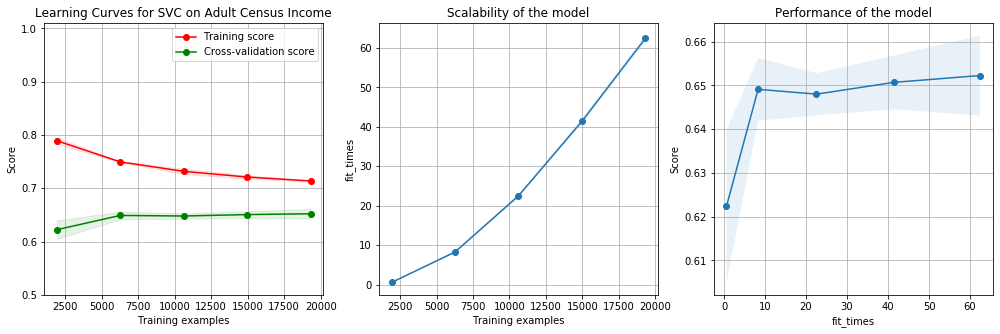

In [43]:
plot_learning_curves(ac_svm_tuned, "ac")

# Boosting
*Implement or steal a boosted version of your decision trees. As before, you will want to use some form of pruning, but presumably because you're using boosting you can afford to be much more aggressive about your pruning.*

## Boosting - Fashion MNIST

In [ ]:
fm_adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=20, learning_rate=1, random_state=42)
compute_mean_cv_score(fm_adaboost, "fm")

0.7869999999999999

In [46]:
fm_adaboost = AdaBoostClassifier(random_state=42)
params = {
    "base_estimator": [DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=1)],
    "n_estimators": [10, 20, 30, 50],
    "learning_rate": [0.1, 0.3, 0.5, 0.8, 1]
}
fm_adaboost_gcv = GridSearchCV(fm_adaboost, params, scoring=get_scoring_function("fm"), n_jobs=-1, verbose=5)
fm_adaboost_gcv.fit(fm_x_train, fm_y_train)
fm_adaboost_gcv.best_params_

fm_adaboost_tuned = fm_adaboost_gcv.best_estimator_
compute_mean_cv_score(fm_adaboost_tuned, "fm")

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.1min finished


0.821

In [47]:
fm_adaboost_gcv.best_params_

{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=3, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'learning_rate': 0.3,
 'n_estimators': 20}

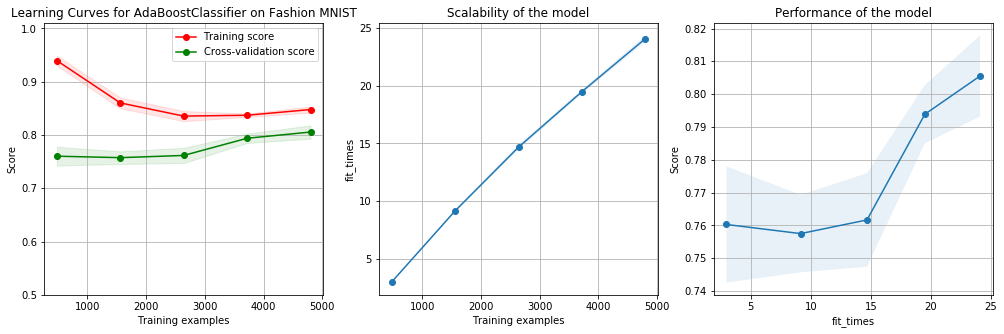

In [49]:
plot_learning_curves(fm_adaboost_tuned, "fm")

## Boosting - Adult Census Income

In [50]:
ac_adaboost = AdaBoostClassifier(random_state=42)
compute_mean_cv_score(ac_adaboost, "ac")

0.6781627099022449

In [51]:
ac_adaboost = AdaBoostClassifier(random_state=42)
params = {
    "base_estimator": [DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=1)],
    "n_estimators": [10, 20, 30, 50],
    "learning_rate": [0.1, 0.3, 0.5, 0.8, 1]
}
ac_adaboost_gcv = GridSearchCV(ac_adaboost, params, scoring=get_scoring_function("ac"), n_jobs=-1, verbose=5)
ac_adaboost_gcv.fit(ac_x_train, ac_y_train)
ac_adaboost_gcv.best_params_

ac_adaboost_tuned = ac_adaboost_gcv.best_estimator_
compute_mean_cv_score(ac_adaboost_tuned, "ac")

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.6min finished


0.7065509219194303

In [52]:
ac_adaboost_gcv.best_params_

{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=3, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'learning_rate': 1,
 'n_estimators': 30}

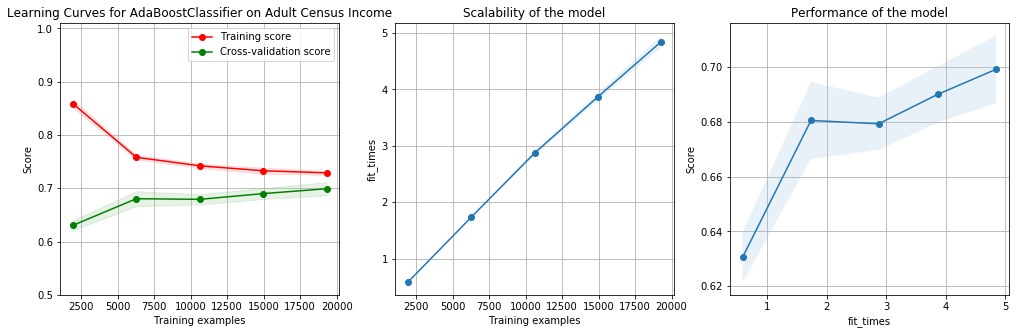

In [53]:
plot_learning_curves(ac_adaboost_tuned, "ac")

# MLP
*For the neural network you should implement or steal your favorite kind of network and training algorithm. You may use networks of nodes with as many layers as you like and any activation function you see fit.*

**TODO**: Plot learning curves with number_iterations vs accuracy

## MLP - Fashion MNIST

In [ ]:
# FM
fm_mlp = MLPClassifier(hidden_layer_sizes=(30,30, 30), alpha=1, max_iter=700)
compute_mean_cv_score(fm_mlp, "fm")

0.8005000000000001

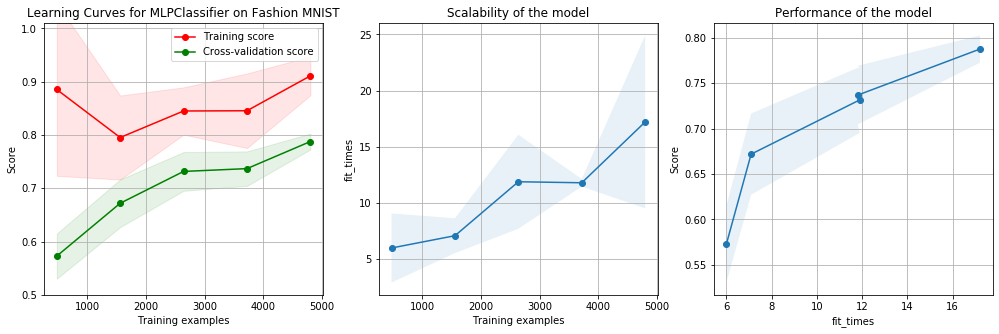

In [ ]:
plot_learning_curves(fm_mlp, "fm")

**Notes on learning curves**

Overfit in the learning curves has been reduced by limiting the number of layers and neurons per layer

## MLP - Income

In [22]:
# MC
ac_mlp = MLPClassifier(hidden_layer_sizes=(30,30), alpha=1, max_iter=700)
compute_mean_cv_score(ac_mlp, "ac")

0.6576420595452671

**Notes**
- F1 was at 0.70 before hot encoding. Should we not hot encode?